# initialize the Modules

src : https://towardsdatascience.com/10-minutes-to-building-a-binary-image-classifier-by-applying-transfer-learning-to-mobilenet-eab5a8719525 ; https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2 ; https://www.youtube.com/watch?v=w8Qx40tHeEM&ab_channel=SebastiaanMath%C3%B4t ; https://colab.research.google.com/drive/1XYAXOHiXNWqmKedCj1WRcJ6mGpr4aVC0?usp=sharing

In [1]:
!pip3 install keras keras_applications keras_preprocessing Keras-Applications sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.4 MB/s 


In [2]:
#store working directory
!pwd
!workingDir=$(pwd)

/content


In [3]:
import keras

In [4]:
keras.__version__

'2.8.0'

## Initialize the Machine Learning Modules Tensorflow

In [5]:
import tensorflow as tf
import keras.applications.mobilenet_v2 as MN2
import numpy as np
from imageio import imread

In [6]:

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2 as MN2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

### Initiate the model of MN2 or mobilenet

In [7]:
model = Sequential()

### The Layers

In [81]:
"""
How about if we put the sandwich 0. MN2 1. Pooling MN2 2. Convolution?(for feature sharpening) 3. Dense sigmoid
"""
input_shape=(300, 300, 3)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = "relu", input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = "relu"),
    tf.keras.layers.MaxPooling2D(2,2), 
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(5, activation='softmax')  
])

#model.add(MN2(include_top = False, weights="imagenet", input_shape=input_shape))
#224, 224, 3 depending on the original model in this case imagenet on MN2 is 224 224 3
#model.add(Flatten(input_shape=input_shape))
#model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size=(3,3), activation = "relu", input_shape=input_shape))
# model.add(tf.keras.layers.MaxPooling2D(2,2))
# model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = "relu"))
# model.add(tf.keras.layers.MaxPooling2D(2,2))
# model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = "relu"))
# model.add(tf.keras.layers.MaxPooling2D(2,2))
# #model.add(tf.keras.layers.GlobalAveragePooling2D())
# #model.add(tf.keras.layers.Flatten())
# #model.add(Dense(units = 256, activation = 'sigmoid'))
# #model.add(Dense(units = 128, activation = 'relu'))
# #model.add(Dense(units = 30, activation = 'softmax')) softmax biasanya buat di layer terakhir untuk klasifikasi
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(Dense(5, activation = 'softmax')) # 5 itu disesuaikan classnya ada berapa
# # set layers 0 to be untrainable
# model.layers[0].trainable = False

In [90]:
#after adding the layers of cheese combine it by compile it
from tensorflow.keras.optimizers import RMSprop
#model.compile(optimizer=RMSprop(learning_rate=0.01), loss = 'binary_crossentropy', metrics = 'accuracy')
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 149, 149, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 149, 149, 64)     256       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 149, 149, 64)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 147, 147, 32)      18464     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 73, 73, 32)      

# Retrofitting Training Data

> We are going to use yoga_poses dataset that is originated from the tensorflow   !wget -O yoga_poses.zip http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
which includes 5 pose

1. Chair
2. Cobra
3. Dog
4. Tree
5. Warrior

In [73]:
!pwd; apt install wget -y; rm -f yoga_poses.zip ; rm -rf train test; wget http://download.tensorflow.org/data/pose_classification/yoga_poses.zip; rm -rf trainingDataset; mkdir trainingDataset; mv yoga_poses.zip trainingDataset

/content
Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
--2022-06-12 04:44:28--  http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.152.128, 2607:f8b0:4001:c56::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.152.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102517581 (98M) [application/zip]
Saving to: ‘yoga_poses.zip’

yoga_poses.zip      100%[===================>]  97.77M  89.3MB/s    in 1.1s    

2022-06-12 04:44:30 (89.3 MB/s) - ‘yoga_poses.zip’ saved [102517581/102517581]



In [72]:
! rm -R /content/trainingDataset

In [74]:
!pwd; ls; apt install zip -y; cd trainingDataset; unzip yoga_poses.zip

/content
sample_data  trainingDataset
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Archive:  yoga_poses.zip
  inflating: LICENSE                 
   creating: test/
   creating: test/cobra/
  inflating: test/cobra/guy3_cobra105.jpg  
  inflating: test/cobra/guy3_cobra058.jpg  
  inflating: test/cobra/guy3_cobra117.jpg  
  inflating: test/cobra/guy3_cobra118.jpg  
  inflating: test/cobra/guy3_cobra084.jpg  
  inflating: test/cobra/guy3_cobra078.jpg  
  inflating: test/cobra/guy3_cobra027.jpg  
  inflating: test/cobra/guy3_cobra056.jpg  
  inflating: test/cobra/guy3_cobra120.jpg  
  inflating: test/cobra/guy3_cobra090.jpg  
  inflating: test/cobra/guy3_cobra095.jpg  
  inflating: test/cobra/gu

In [20]:
!cd ${workingDir} 

### set variable for the training path

In [21]:
#/home/albertstarfield/Documents/FileSekolah13(TE)/bangkit_error/runtime/Motionful-Project-Bangkit2022/src/MachineLearning/model/transferLearningRetrofitting_MobileNet
import os

trainingPath = './trainingDataset/train/'
validationPath = './trainingDataset/test/'

#Training Path
Train_chairPath = "./trainingDataset/train/chair"
trainChairPose = os.listdir(Train_chairPath)
print('total Chair Pose Images', len(trainChairPose))
Train_cobraPath = "./trainingDataset/train/cobra"
trainCobraPose = os.listdir(Train_cobraPath)
print('total cobra Pose Images', len(trainCobraPose))
train_dogPath = "./trainingDataset/train/dog"
trainDogPose = os.listdir(train_dogPath)
print('total dog Pose Images', len(trainDogPose))
train_treePath = "./trainingDataset/train/tree"
trainTreePose = os.listdir(train_treePath)
print('total tree Pose Images', len(trainTreePose))
train_warriorPath = "./trainingDataset/train/warrior"
trainWarriorPose = os.listdir(train_warriorPath)
print('total warrior Pose Images', len(trainWarriorPose))

#Testing or Validation Path
Validation_chairPath = "./trainingDataset/train/chair"
validationChairPose = os.listdir(Validation_chairPath)
print('total Chair Pose Images', len(validationChairPose))
Validation_cobraPath = "./trainingDataset/train/cobra"
validationCobraPose = os.listdir(Validation_cobraPath)
print('total cobra Pose Images', len(validationCobraPose))
Validation_dogPath = "./trainingDataset/train/dog"
validationDogPose = os.listdir(Validation_dogPath)
print('total dog Pose Images', len(validationDogPose))
Validation_treePath = "./trainingDataset/train/tree"
validationTreePose = os.listdir(Validation_treePath)
print('total tree Pose Images', len(validationTreePose))
Validation_warriorPath = "./trainingDataset/train/warrior"
trainWarriorPose = os.listdir(Validation_warriorPath)
print('total warrior Pose Images', len(trainWarriorPose))

total Chair Pose Images 200
total cobra Pose Images 200
total dog Pose Images 200
total tree Pose Images 200
total warrior Pose Images 200
total Chair Pose Images 200
total cobra Pose Images 200
total dog Pose Images 200
total tree Pose Images 200
total warrior Pose Images 200


### Visualizing dataset using data matplotlib

In [22]:
%matplotlib inline

import matplotlib.pyplot as plot
import matplotlib.image as mpimg

#view it as 5x5
Visrows = 5
Viscols = 5
picIndex = 0 #starts index from 0

ValueError: ignored

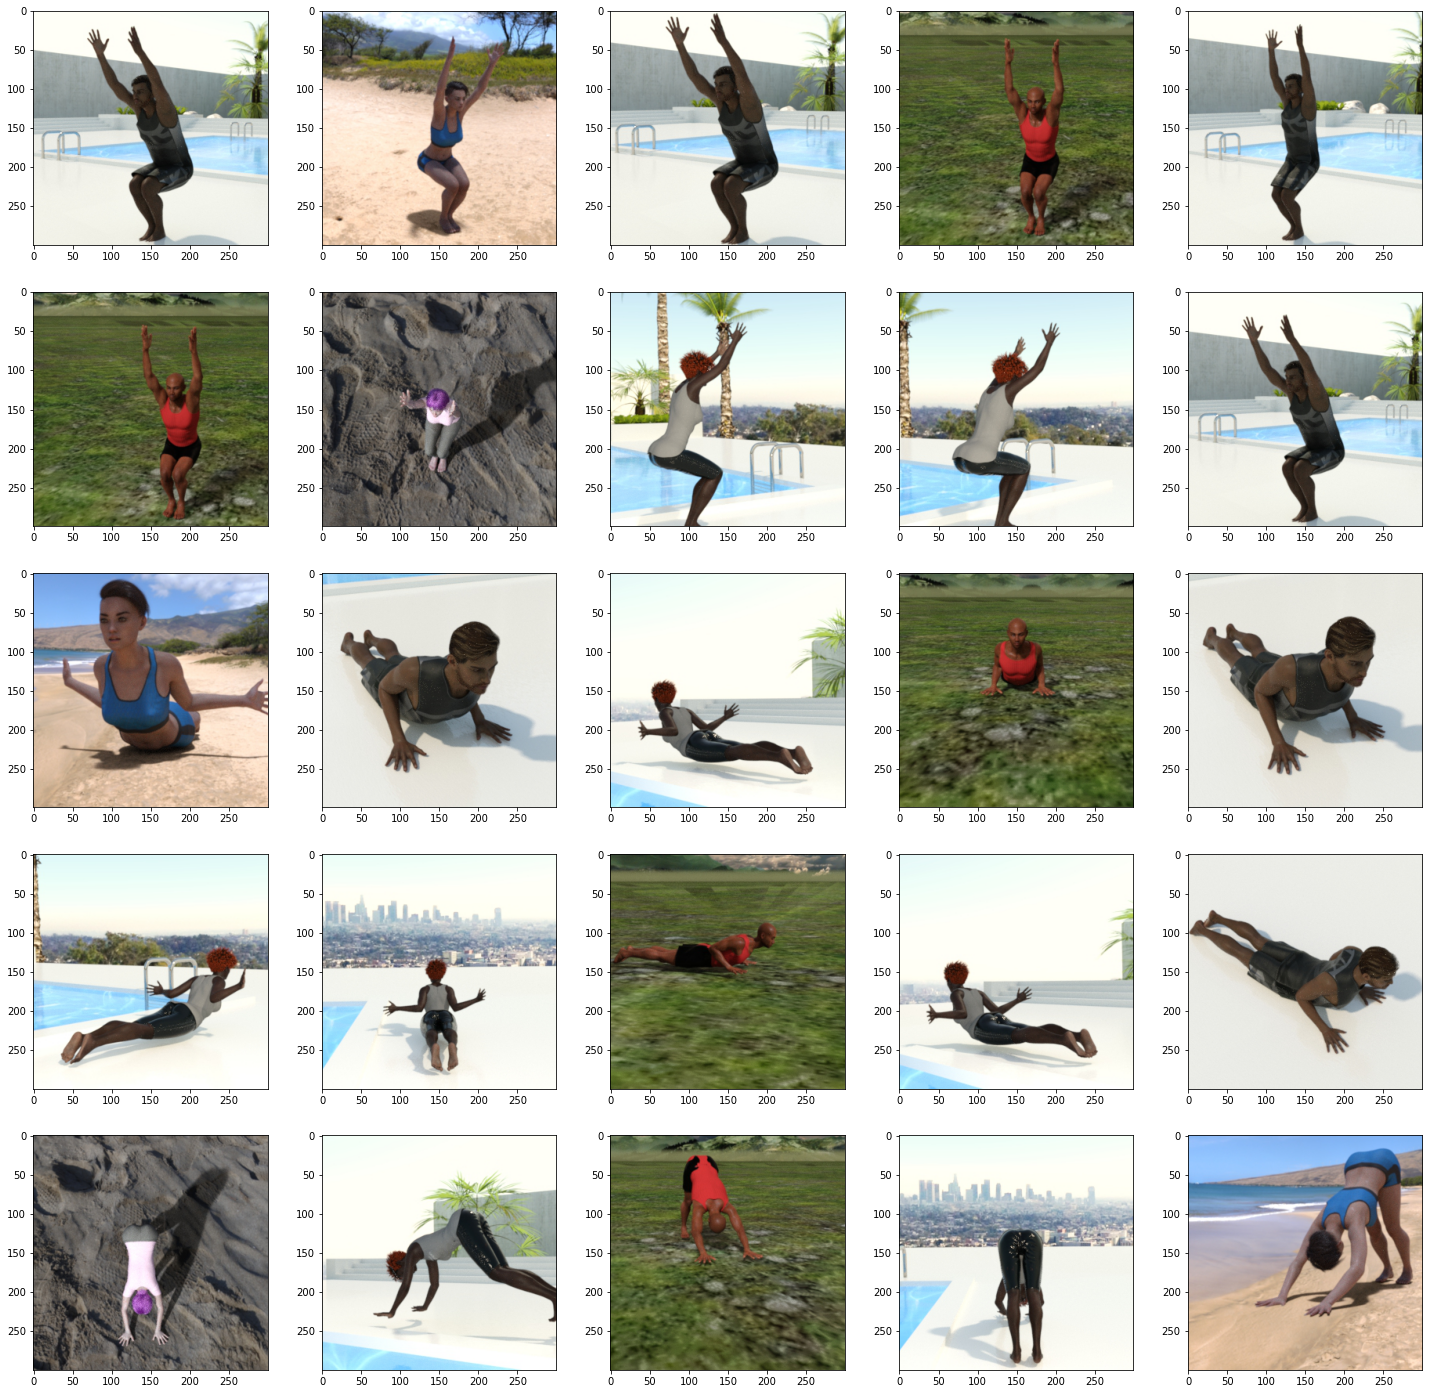

In [25]:
#view dataset images by using matplotlib
figure = plot.gcf()
figure.set_size_inches(Visrows * 5, Viscols * 5)
#add index +10 because we are going through 10 photos now
picIndex += 10
# view all classification of the pose
"""
Chair
Cobra
Dog
Tree
Warrior

#Training Path
Train_chairPath = "./trainingDataset/train/chair"
trainChairPose = os.listdir(Train_chairPath)
print('total Chair Pose Images', len(trainChairPose))
Train_cobraPath = "./trainingDataset/train/cobra"
trainCobraPose = os.listdir(Train_cobraPath)
print('total cobra Pose Images', len(trainCobraPose))
train_dogPath = "./trainingDataset/train/dog"
trainDogPose = os.listdir(train_dogPath)
print('total dog Pose Images', len(trainDogPose))
train_treePath = "./trainingDataset/train/tree"
trainTreePose = os.listdir(train_treePath)
print('total tree Pose Images', len(trainTreePose))
train_warriorPath = "./trainingDataset/train/warrior"
trainWarriorPose = os.listdir(train_warriorPath)
print('total warrior Pose Images', len(trainWarriorPose))
"""

seekChairData = [os.path.join(Train_chairPath, fname) for fname in trainChairPose[picIndex-10:picIndex]]
seekCobraData = [os.path.join(Train_cobraPath, fname) for fname in trainCobraPose[picIndex-10:picIndex]]
seekDogData = [os.path.join(train_dogPath, fname) for fname in trainDogPose[picIndex-10:picIndex]]
seekTreeData = [os.path.join(train_treePath, fname) for fname in trainTreePose[picIndex-10:picIndex]] 
seekWarriorData = [os.path.join(train_warriorPath, fname) for fname in trainWarriorPose[picIndex-10:picIndex]] 

for a, imPath in enumerate(seekChairData + seekCobraData + seekDogData + seekTreeData + seekWarriorData):
  subPlot = plot.subplot(Visrows, Viscols, a + 1)
  subPlot.axis('On') #i wanna see the axis and the gridline
  image = mpimg.imread(imPath)
  plot.imshow(image)
plot.show() 

### data resizing and classification

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as dataGen

#lets target the scaling res
#rescaling 244 244
trainDatagen = dataGen() #1/255
validationDatagen = dataGen() #1/255
"""
Chair
Cobra
Dog
Tree
Warrior
"""
trainDataGenerator = trainDatagen.flow_from_directory(
    trainingPath,
    target_size = (300, 300),
    batch_size = 30,
    class_mode='categorical'
)

trainingValidationGenerator = validationDatagen.flow_from_directory(
    validationPath,
    target_size = (300, 300),
    batch_size = 30,
    class_mode='categorical',
)

Found 1000 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


# Train time!

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/checkpoint', save_best_only=True)

history = model.fit(trainDataGenerator,
                    validation_data=trainingValidationGenerator,
                    epochs=20,
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/20
34/34 [==============================] - 8s 216ms/step - loss: 0.1058 - accuracy: 0.9880 - val_loss: 7.0894 - val_accuracy: 0.3758
Epoch 2/20
34/34 [==============================] - 7s 207ms/step - loss: 4.8263e-05 - accuracy: 1.0000 - val_loss: 6.8115 - val_accuracy: 0.3556
Epoch 3/20
34/34 [==============================] - 6s 176ms/step - loss: 4.7350e-06 - accuracy: 1.0000 - val_loss: 7.0725 - val_accuracy: 0.3596
Epoch 4/20
34/34 [==============================] - 6s 175ms/step - loss: 2.0207e-06 - accuracy: 1.0000 - val_loss: 7.2784 - val_accuracy: 0.3354
Epoch 5/20
34/34 [==============================] - 6s 174ms/step - loss: 7.9000e-07 - accuracy: 1.0000 - val_loss: 7.7608 - val_accuracy: 0.3313
Epoch 6/20
34/34 [==============================] - 6s 175ms/step - loss: 3.4256e-04 - accuracy: 1.0000 - val_loss: 12.5213 - val_accuracy: 0.2444
Epoch 7/20
34/34 [==============================] - 6s 176ms/step - loss: 0.1109 - accuracy: 0.9860 - val_loss: 10.2205 - val_a

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Export Model h5 and tflite

In [ ]:
model.evaluate(trainingValidationGenerator)

In [ ]:
model.save('motionful_prealpha.h5')

In [ ]:
!ls 

### converting h5 to tflite

In [ ]:
# Write the classificaiton
! echo "chair" > motionful_prealpha_classification.txt
! echo "cobra" >> motionful_prealpha_classification.txt
! echo "dog" >> motionful_prealpha_classification.txt
! echo "tree" >> motionful_prealpha_classification.txt
! echo "warrior" >> motionful_prealpha_classification.txt

In [ ]:
modelLoad = tf.keras.models.load_model('motionful_prealpha.h5')
converterModel = tf.lite.TFLiteConverter.from_keras_model(modelLoad)
tfLiteModelExport = converterModel.convert()
open("motionful_prealpha.tflite", "wb").write(tfLiteModelExport)

# Download zip archive the model

In [ ]:
import files
files.download('motionful_prealpha.tflite')
files.download('motionful_prealpha.h5')
files.download('motionful_prealpha_classification.txt')